<a href="https://colab.research.google.com/github/ydeng-MLM/MLM_Lab_Miscellaneous/blob/main/TDS_data_post_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit

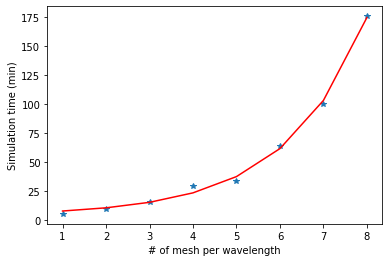

In [ ]:
m = np.array((1,2,3,4,5,6,7,8))
t = np.array((5.6, 10, 16, 30, 33.9, 64.2, 99.9, 175.5))
plt.plot(m,t, '*')
plt.xlabel("# of mesh per wavelength")
plt.ylabel("Simulation time (min)")

def func(x, a, b, c):
    return a * np.exp(b * x) + c
xdata = m
ydata = t

popt, pcov = curve_fit(func, xdata, ydata)

plt.plot(xdata, func(xdata, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

In [ ]:
class TDS:
  def __init__(self, fname='content/test', fn1=1, fn2=4, peak=1, filter=True, fw='hanning'):
    self.fname = fname
    self.fn1 = fn1
    self.fn2 = fn2
    self.peak = peak
    self.filter = filter
    self.filter_window = fw

  def time_data(self):
    li_data = []
    for i in range(self.fn1,self.fn2+1):
      df_data = pd.read_csv(self.fname+str(i)+'_0.txt', sep='\t', header=1)
      li_data.append(df_data)   

    temp = pd.concat(li_data, axis=1, ignore_index=True)
    data = temp.to_numpy()

    time, time_data = self.filter_TDS(data)
    return time, time_data

  def filter_TDS(self, data):
    bandwidth = 50

    time = data[:,0]
    arr_shift = np.zeros((300, int(data.shape[1]/2)))
    for i in range(1,data.shape[1],2):
      max_index = 0
      for j in range(self.peak):
        max_index += bandwidth+np.argmax(abs(data[max_index+bandwidth:,i]))

      data[max_index+bandwidth:,i]=0
      data[:max_index-bandwidth,i]=0
      data[max_index-bandwidth:max_index+bandwidth,i]= data[max_index-bandwidth:max_index+bandwidth,i]*np.hanning(2*bandwidth)
      arr_shift[:,int((i-1)/2)] = data[max_index-5*bandwidth:max_index+bandwidth,i]
    time = time[max_index-5*bandwidth:max_index+bandwidth]

    avg = np.mean(arr_shift, axis=1)
    return time, avg

  def freq_data(self):
    x, sample = self.time_data()
    x = x - min(x)
    freq = np.fft.rfftfreq(len(sample), d=x[1]-x[0])
    samplef = abs(np.fft.rfft(sample))
    return freq, samplef

  def plot(self):
    time, time_data = self.time_data()
    freq, freq_data = self.freq_data()

    plt.figure()
    plt.plot(time, time_data, 'r')
    #plt.xlim([680,730])
    plt.xlabel("Time (ps)")
    plt.legend(['Background', 'Sample'])
    plt.savefig('time_domain.jpg',dpi=300)

    plt.figure()
    plt.plot(freq, freq_data, 'r')
    #plt.xlim([0,3.5])
    plt.xlabel("Frequency (THz)")
    plt.legend(['Background', 'Sample'])
    plt.savefig('freq_domain.jpg',dpi=300)

  def plot_compare(self, ref, ref1):
    time, time_data = self.time_data()
    freq, freq_data = self.freq_data()

    ref_time, ref_time_data = ref.time_data()
    ref_freq, ref_freq_data = ref.freq_data()

    ref1_time, ref1_time_data = ref1.time_data()
    ref1_freq, ref1_freq_data = ref1.freq_data()

    plt.figure()
    plt.plot(time, ref_time_data, 'r')
    plt.plot(time, ref1_time_data, 'b')
    plt.plot(time, time_data, 'g')
    #plt.xlim([709,710])
    plt.xlabel("Time (shifted)")
    plt.legend(['Background', 'Sample', 'Photodoped'])
    plt.savefig('time_domain.jpg',dpi=300)

    plt.figure()
    plt.plot(freq, ref_freq_data, 'r')
    plt.plot(freq, ref1_freq_data, 'b')
    plt.plot(freq, freq_data, 'g')
    plt.xlim([0,3])
    plt.xlabel("Frequency (THz)")
    plt.legend(['Background', 'Sample', 'Photodoped'])
    plt.savefig('freq_domain.jpg',dpi=300)

    ref = ref_freq_data/ref_freq_data
    R = ref1_freq_data/ref_freq_data
    Rd = freq_data/ref_freq_data

    plt.figure()
    plt.plot(freq, ref, 'r')
    plt.plot(freq, R, 'b')
    plt.plot(freq, Rd, 'g')
    plt.xlim([0.2,3.5])
    plt.ylim([0,1.5])
    plt.xlabel("Frequency (THz)")
    plt.ylabel("Reflectance Coefficient")
    plt.legend(['Background', 'Sample', 'photodope'])
    plt.savefig('reflectivity_coe.jpg', dpi=300)

    t = np.asarray([time, ref_time_data, ref1_time_data, time_data])
    np.savetxt("MFPA_photodoping_TDS_data_040121_t_averaged.csv", t.T, delimiter=",", fmt='%1.6f', header="time,mirror,sample,photodoped")
    a = np.asarray([freq, ref_freq_data, ref1_freq_data, freq_data])
    np.savetxt("MFPA_photodoping_TDS_data_040121_f_averaged.csv", a.T, delimiter=",", fmt='%1.6f', header="freq,mirror,sample,photodoped")
        

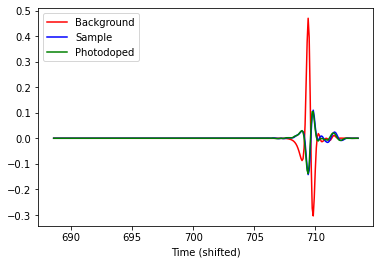

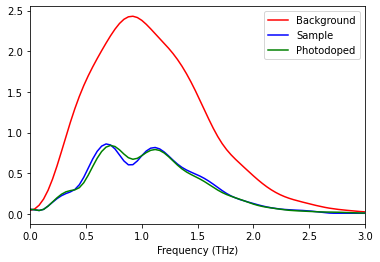

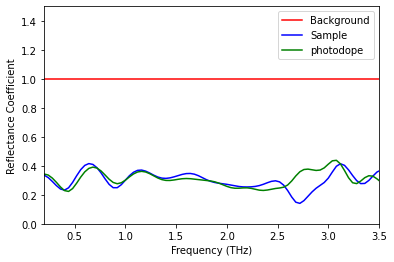

In [ ]:
ref = TDS('/content/data/ref_', 1, 4)
non_shift = TDS('/content/data/sample_', 1,9, peak=2)
non_shift_pd = TDS('/content/data/photodope_', 1,9, peak=2)

#non_shift.plot_compare(ref)
non_shift_pd.plot_compare(ref,non_shift)

(300, 1)
(300, 1)


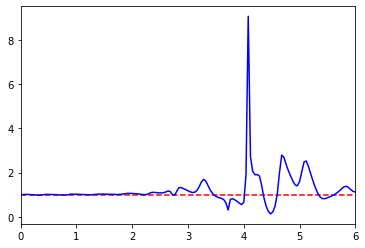

In [ ]:
ref1 = TDS('/content/data/sample_', 7,7,peak=2)
ref2 = TDS('/content/data/sample_', 9,9,peak=2)

freq1, data1 = ref1.freq_data()
freq2, data2 = ref2.freq_data()

ref = data1/data1
hun = data2/data1

plt.plot(freq1,ref,'--r')
plt.plot(freq1,hun,'b')
plt.xlim([0, 6])

a = np.asarray([freq1, hun])
np.savetxt("MFPA_photodoping_TDS_data_040121_100line.csv", a.T, delimiter=",", fmt='%1.6f', header="freq,Reflectance")

In [ ]:
'''
def filter_TDS(data):
  avg = np.mean(data[:, 1::2], axis=1)
  avg = avg-np.mean(avg[:100])
  
  bandwidth = 5*abs(np.argmax(avg)-np.argmin(avg))

  #avg = smooth(avg,11)
  
  #avg[np.argmax(avg)+bandwidth:]=0
  
  peak1 = np.argmax(avg)
  peak2 = peak1+bandwidth+np.argmax(avg[peak1+bandwidth:])
  peak3 = peak2+bandwidth+np.argmax(avg[peak2+bandwidth:])
  peak4 = peak3+bandwidth+np.argmax(avg[peak3+bandwidth:])

  a1 = avg[peak1]/avg[peak1]
  a2 = avg[peak2]/avg[peak1]
  a3 = avg[peak3]/avg[peak1]
  a4 = avg[peak4]/avg[peak1]

  print(a1, a2, a3)

  avg[peak2-bandwidth:peak2+bandwidth] = avg[peak2-bandwidth:peak2+bandwidth]-(avg[peak1-bandwidth:peak1+bandwidth]*a2)
  avg[peak3-bandwidth:peak3+bandwidth] = avg[peak3-bandwidth:peak3+bandwidth]-(avg[peak1-bandwidth:peak1+bandwidth]*a3)
  avg[peak4-bandwidth:peak4+bandwidth] = avg[peak4-bandwidth:peak4+bandwidth]-(avg[peak1-bandwidth:peak1+bandwidth]*a3)
  test = avg[peak2-bandwidth:peak2+bandwidth]/(avg[peak1-bandwidth:peak1+bandwidth]*a2)
  print(test.shape)
  
  time = data[:,0]

  return time, avg[:len(time)]
'''

'\ndef filter_TDS(data):\n  avg = np.mean(data[:, 1::2], axis=1)\n  avg = avg-np.mean(avg[:100])\n  \n  bandwidth = 5*abs(np.argmax(avg)-np.argmin(avg))\n\n  #avg = smooth(avg,11)\n  \n  #avg[np.argmax(avg)+bandwidth:]=0\n  \n  peak1 = np.argmax(avg)\n  peak2 = peak1+bandwidth+np.argmax(avg[peak1+bandwidth:])\n  peak3 = peak2+bandwidth+np.argmax(avg[peak2+bandwidth:])\n  peak4 = peak3+bandwidth+np.argmax(avg[peak3+bandwidth:])\n\n  a1 = avg[peak1]/avg[peak1]\n  a2 = avg[peak2]/avg[peak1]\n  a3 = avg[peak3]/avg[peak1]\n  a4 = avg[peak4]/avg[peak1]\n\n  print(a1, a2, a3)\n\n  avg[peak2-bandwidth:peak2+bandwidth] = avg[peak2-bandwidth:peak2+bandwidth]-(avg[peak1-bandwidth:peak1+bandwidth]*a2)\n  avg[peak3-bandwidth:peak3+bandwidth] = avg[peak3-bandwidth:peak3+bandwidth]-(avg[peak1-bandwidth:peak1+bandwidth]*a3)\n  avg[peak4-bandwidth:peak4+bandwidth] = avg[peak4-bandwidth:peak4+bandwidth]-(avg[peak1-bandwidth:peak1+bandwidth]*a3)\n  test = avg[peak2-bandwidth:peak2+bandwidth]/(avg[peak1-b

In [ ]:
ref = f_back1/f_back
T = f_03/f_back

plt.figure
plt.plot(freq_back, T, 'b')
plt.plot(freq_back, ref, 'r')
plt.xlim([0.2,3.5])
plt.ylim([0,1.5])
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmittance Coefficient")
plt.legend(['Sample', '100% line'])
plt.savefig('reflectivity_coe.jpg', dpi=300)

NameError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


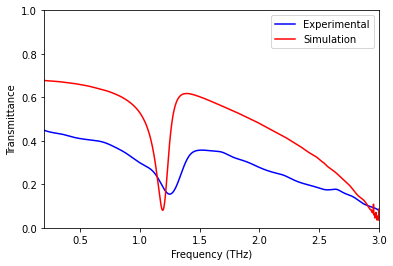

In [ ]:
T_sim = np.power(read_CST('/content/MMonly_on_GaAs_T.txt'),2)
freq_sim = np.linspace(0, 3, len(T_sim))
A = np.power(T,2)

plt.figure
plt.plot(freq_back, A, 'b')
plt.plot(freq_sim, T_sim, 'r')
plt.xlim([0.2,3])
plt.ylim([0,1])
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmittance")
plt.legend(['Experimental', 'Simulation'])
#plt.legend(['Experimental', 'Simulation'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
plt.savefig('sim_exp_comparison.jpg', dpi=300)